## MNISTを使った数字認識

これまでの例題はPyTorchの使い方を知るための単なる例題で、一般的に「深層学習」と呼ばれているモノではない。

深層学習は、隠れ層の数が２層以上のモノをいい、隠れ層同士の間には、活性化関数（レイヤ関数とも）と呼ばれる、
非線形関数を挟む（他の非線形関数はp.138、表4-1にある）。

非線形関数を挟まないと、隠れ層の層数をいくら増やそうが、１階層のモデルと等価である。

以下の例は、計算が非常に重いので**Google Colabo上でGPUを使って走らせる**ことを想定している。

### 活性化関数

まず、活性化関数について、おさらいする。

In [2]:
! pip install japanize_matplotlib 2> /dev/null | tail -1

In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

random_seed = 123

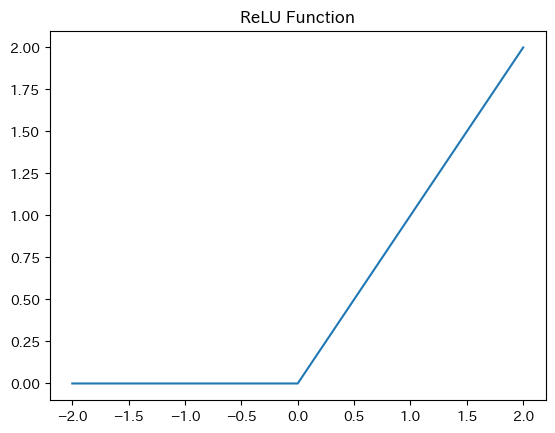

In [4]:
relu = nn.ReLU()

x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU Function')
plt.show()

Definition of Rectified Linear Unit, i.e., ReLU, function is

$f(x) =
\left\{
\begin{array}{cr}
0,\hspace{0.5cm} x \leq 0, \\
x,\hspace{0.5cm} x \gt 0.
\end{array}
\right.$

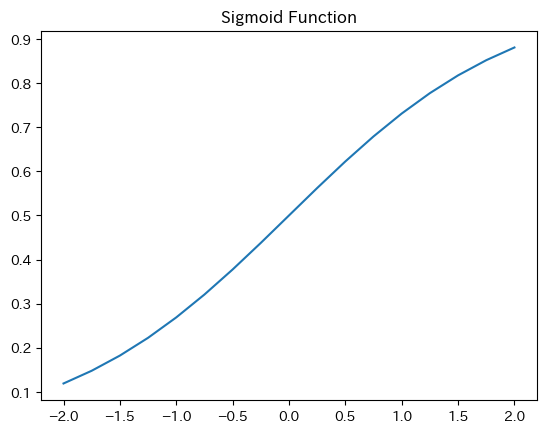

In [5]:
sigmoid = nn.Sigmoid()
y = sigmoid(x)

plt.plot(x.data, y.data)
plt.title('Sigmoid Function')
plt.show()

Definition of sigmoid function is

$f(x) = \cfrac{1}{1 - \exp{\left(-x\right)}}$

which is used to transform a scalar value into some probability.

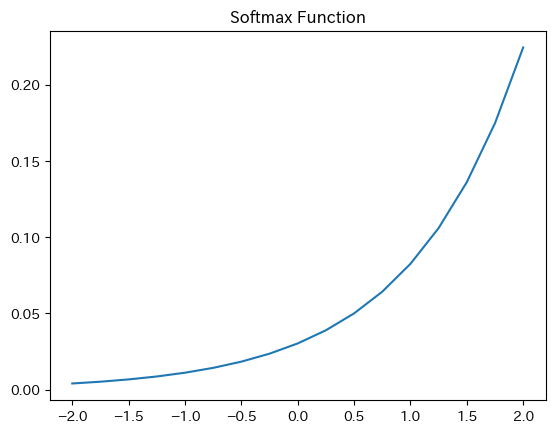

In [6]:
#softmax = nn.Softmax() # Implicit dimension choice for softmax has been deprecated. we have to specify `dim` keyword variable as follows.
softmax = nn.Softmax(dim=0)
y = softmax(x)

plt.plot(x.data, y.data)
plt.title('Softmax Function')
plt.show()

Definition of softmax function is

$y_i = \cfrac{\exp{\left(x_i\right)}}{\sum_{k=1}^n\exp{\left(x_k\right)}}$

which is obviously used for multiple-class classification.

### GPUの設定

Google Colaboのメニューで Runtime > Change running typeからT4 GPUを選択する。

以下でGPUが使われていることを確認する。

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f'device count: {torch.cuda.device_count()}')
print(f'device name: {torch.cuda.get_device_name()}')
print(f'device capability: {torch.cuda.get_device_capability()}')

cuda:0
device count: 1
device name: Tesla T4
device capability: (7, 5)


In [17]:
import os

key = 'CUDA_VISIBLE_DEVICES'

if key in os.environ:
  print(f'{key}: {os.environ[key]}')
else:
  print(f'"{key}" is not defined as environment variable')

# when CUDA_VISIBLE_DEVICES env is set to -1, use of GPU is refrained even if it is available

"CUDA_VISIBLE_DEVICES" is not defined as environment variable


TensorFlowではKerasを用いて、GPUとCPUの処理を意識せずに走らせることができる。

PyTorchは、コードを書く時点で、ユーザが手動で制御しないといけない。各テンソルは
CPU上か、GPU上か、という状態をもち、同じ状態をもつテンソル同士しか計算できない。
異なる状態の場合は、エラーになる！

In [22]:
x_np = np.arange(-2, 2.1, 0.25)
y_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

z = x * y
z

tensor([4.0000, 3.0625, 2.2500, 1.5625, 1.0000, 0.5625, 0.2500, 0.0625, 0.0000,
        0.0625, 0.2500, 0.5625, 1.0000, 1.5625, 2.2500, 3.0625, 4.0000])

In [23]:
x.to(device) # This is not destructive method

z = x * y
z

tensor([4.0000, 3.0625, 2.2500, 1.5625, 1.0000, 0.5625, 0.2500, 0.0625, 0.0000,
        0.0625, 0.2500, 0.5625, 1.0000, 1.5625, 2.2500, 3.0625, 4.0000])

In [24]:
x = x.to(device)

z = x * y
z

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

モデルのインスタンスに関しても、テンソルと同様、CPU上か、GPU上かを明示的に指定する。

### データの読み込み

In [25]:
import torchvision.datasets as datasets

data_root = './data'

mnist_train = datasets.MNIST(root=data_root, train=True, download=True)
mnist_test = datasets.MNIST(root=data_root, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4529736.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 64844.99it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1077933.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8527541.97it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:
! ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Sep 20 02:41 raw

./data/MNIST/raw:
total 65012
-rw-r--r-- 1 root root  7840016 Sep 20 02:41 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Sep 20 02:41 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Sep 20 02:41 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Sep 20 02:41 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Sep 20 02:41 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Sep 20 02:41 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Sep 20 02:41 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Sep 20 02:41 train-labels-idx1-ubyte.gz


NameError: name 'train_set' is not defined

In [28]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [29]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [34]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

28x28の画像と分かる。また、画像にはラベル（回答の数字）が付けられている。

In [45]:
image, label = mnist_train[0]

In [46]:
type(image), type(label)

(PIL.Image.Image, int)

(-0.5, 27.5, 27.5, -0.5)

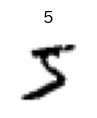

In [47]:
plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')

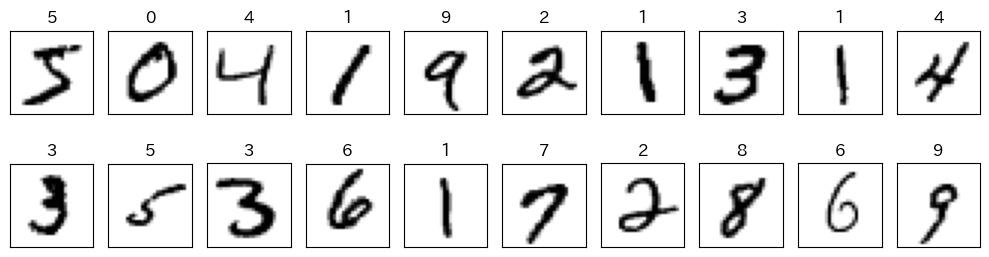

In [49]:
plt.figure(figsize=(10, 3))

for ii in range(20):
  ax = plt.subplot(2, 10, ii + 1)
  image, label = mnist_train[ii]
  plt.title(f'{label}')
  plt.imshow(image, cmap='gray_r')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()

### データ前処理

In [50]:
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    transforms.ToTensor(),
    ])

train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform1)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )